# Preprocessing of Raw Data using VAE + GAT

This preprocessing step is important to delete noise, standarize data and guarantee a quality analysis for the single cell RNA sequencing.

#### Import Libraries and data

In [ ]:
!pip install tensorflow==2.10 tqdm

In [ ]:
# pip install scanpy anndata scrublet matplotlib seaborn numpy pandas scipy scikit-learn
!pip install scrublet os
!pip install mygene
import mygene
import scanpy as sc
import anndata as ad
import scrublet as scr
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from IPython.core.display import display, HTML
import os, json, sys, re
import torch.nn as nn
# from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torch_geometric.nn import GATConv, GCNConv
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as stats
import umap
from sklearn.cluster import DBSCAN
import tensorflow as tf
import torch
import torch.nn.functional as F


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


C:\Users\henry\AppData\Local\Temp\ipykernel_9688\3761028485.py:14: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [747]:
import warnings
# Suppress the specific FutureWarning and UserWarning
warnings.filterwarnings('ignore', category=FutureWarning, 
                       message="The default value of 'ignore' for the `na_action` parameter")
warnings.filterwarnings('ignore', category=UserWarning, 
                       message="No data for colormapping provided via 'c'")

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in log2")

#### Data Load

In [748]:
data_path = "C:/Users/henry/Desktop/python/jbook_rna/datos/Single-cell RNASeq data from Mouse Brain"
data_path2 = "C:/Users/henry/Desktop/python/jbook_rna/datos/Theory - Intro to single-cell RNAseq Images"

In [749]:
glioblastoma_norm_file = os.path.join(data_path, "glioblastoma_normalized.h5ad")
glioblastoma_raw_file = os.path.join(data_path, "glioblastoma_raw.h5ad")
pbmc3k_file = os.path.join(data_path, "pbmc3k.h5ad")

adata_glioblastoma_norm = sc.read_h5ad(glioblastoma_norm_file)
adata_glioblastoma_raw = sc.read_h5ad(glioblastoma_raw_file)
adata_pbmc3k = sc.read_h5ad(pbmc3k_file)

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\anndata\compat\__init__.py:311: FutureWarning:

Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\anndata\compat\__init__.py:311: FutureWarning:

Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.



## Dimensionality reduction

### Using VAE + GAT

```{admonition} What is a variational Autoencoder (VAE)
A Variational Autoencoder (VAE) is a type of deep generative model that learns a probabilistic representation of data. It is widely used for dimensionality reduction, data generation, and representation learning. The VAE is particularly useful for scRNA-seq data because it can handle sparsity and noise while learning meaningful low-dimensional embeddings of cells.
```

*The VAE consists of two main components:*

1. **Encoder**: Maps the input data to a latent space (a lower-dimensional representation).
Outputs a mean (μ) and variance (σ2) for each latent variable, defining a probability distribution.
2. **Decoder**: Reconstructs the input data from the latent space by sampling from the learned distribution.
3. **Loss Function:** Combines 2 terms:
    - Reconstruction Loss: Measures how well the decoder reconstructs the input data.
    - KL Divergence: Ensures the latent space follows a standard normal distribution, enabling smooth sampling.


```{admonition} What is a Graph Attention Network?
A Graph Attention Network (GAT) is a type of neural network designed to operate on graph-structured data. It extends traditional graph neural networks (GNNs) by incorporating attention mechanisms, allowing the model to focus on the most relevant nodes and edges in the graph.
```

1. **Graph Representation:** A graph consists of nodes (e.g., genes or cells) and edges (e.g., interactions or similarities between nodes).
2. **Attention Mechanism:** For each node, the GAT computes attention scores for its neighbors, determining how much influence each neighbor should have.
These scores are learned during training and are used to weight the contributions of neighboring nodes.

#### Why Combine VAE and GAT?

By combining a VAE with a GAT, we can:

- Use the VAE to learn a low-dimensional, probabilistic representation of cells.
- Use the GAT to incorporate prior knowledge (e.g., gene interaction networks) and highlight important regulatory relationships.
- Generate interpretable embeddings where attention weights identify key driver genes or interactions.

In [ ]:
# Install torch_geometric if not already installed
%pip install torch-geometric

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

As we are going to process the standarized data from the sparse matrix that was already preprocessed and may have negative values.

In [795]:
X = torch.tensor(adata_filtered.X, dtype = torch.float32)
n_cells, n_genes = X.shape

In [796]:
print(X[:5, :5])

tensor([[-0.3085, -0.0856, -0.5903, -0.0564, -0.1009],
        [-0.3085, -0.0856, -0.5903, -0.0564, -0.1009],
        [-0.3085, -0.0856, -0.5903, -0.0564, -0.1009],
        [ 1.8309, -0.0856, -0.5903, -0.0564, -0.1009],
        [ 1.4749, -0.0856, -0.5903, -0.0564, -0.1009]])


In [797]:
# Store scaling parameters for inverse transform
data_mean = torch.mean(X, dim=0)
data_std = torch.std(X, dim=0)

```{admonition} What is an Adjacency Matrix?
An adjacency matrix is a square matrix that represents a graph. In the context of a gene interaction network:

- Nodes: Represent genes.
- Edges: Represent interactions or relationships between genes (e.g., regulatory interactions, co-expression, or physical interactions).
```

The adjacency matrix is:

- Binary: If there is an edge between two genes, the value is 1; otherwise, it is 0.
- Weighted: If the strength of the interaction is known, the value can be a weight (e.g., confidence score).

In [798]:
print("Number of genes:", n_genes)

Number of genes: 2000


#### Treshold for correlation

The correlation matrix provides pairwise relationships between genes. However, not all correlations are equally meaningful. By setting a threshold, we create an adjacency matrix, where only correlations above the threshold are considered connections.

In [799]:
# Create correlation-based adjacency matrix
# Convert data to numpy for correlation calculation
gene_expression = X.numpy()

In [800]:
# Calculate correlation matrix
correlation_mmatrix = np.corrcoef(gene_expression.T)

The process begins by computing the **Pearson correlation matrix** from the gene expression data (`X`), where correlations between genes are calculated. Next, different correlation thresholds (`0.3, 0.5, 0.7, 0.9`) are applied to create **binary adjacency matrices**, keeping only correlations above each threshold. For each threshold, the number of actual connections and the **sparsity** (percentage of existing vs. possible connections) are computed. The results are stored in a DataFrame and analyzed. **Threshold 0.5** is chosen as the optimal cutoff because it maintains a balance between network density and sparsity, preserving meaningful connections while filtering out noise.


In [801]:
def analyze_threshold(correlation_matrix, threshold):
    adjacency_matrix = (np.abs(correlation_matrix) > threshold).astype(int)
    np.fill_diagonal(adjacency_matrix, 0)

    total_possible_connections = len(correlation_matrix) * (len(correlation_matrix) - 1) / 2
    actual_connections = np.sum(adjacency_matrix) / 2

    return {
        'threshold': threshold,
        'connections': actual_connections,
        'sparsity': actual_connections / total_possible_connections * 100
    }

In [ ]:
# Calculate correlation matrix if not already done
gene_expression = X.numpy()
correlation_matrix = np.corrcoef(gene_expression.T)

# Test different thresholds
thresholds = [0.3, 0.5, 0.7, 0.9]
results = []

for thresh in thresholds:
    results.append(analyze_threshold(correlation_matrix, thresh))

# Create DataFrame with results
df_results = pd.DataFrame(results)
print("\nThreshold Analysis:")
print(df_results)


Threshold Analysis:
   threshold  connections  sparsity
0        0.3       2222.0  0.111156
1        0.5        233.0  0.011656
2        0.7         32.0  0.001601
3        0.9          2.0  0.000100


**Number of Connections vs Threshold**:  
   - As the threshold increases, the number of retained connections **decreases sharply**.  
   - At **0.3**, there are over 2000 connections, indicating a highly dense network.  
   - By **0.5**, the number of connections drops significantly to around 233, suggesting a balance between connectivity and sparsity.  
   - At **0.7** and **0.9**, very few connections remain, indicating an overly sparse network with minimal relationships preserved.


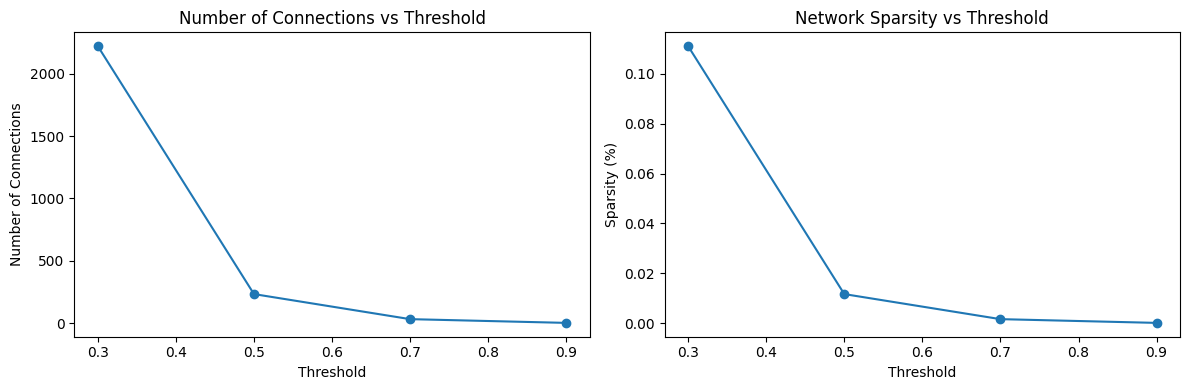

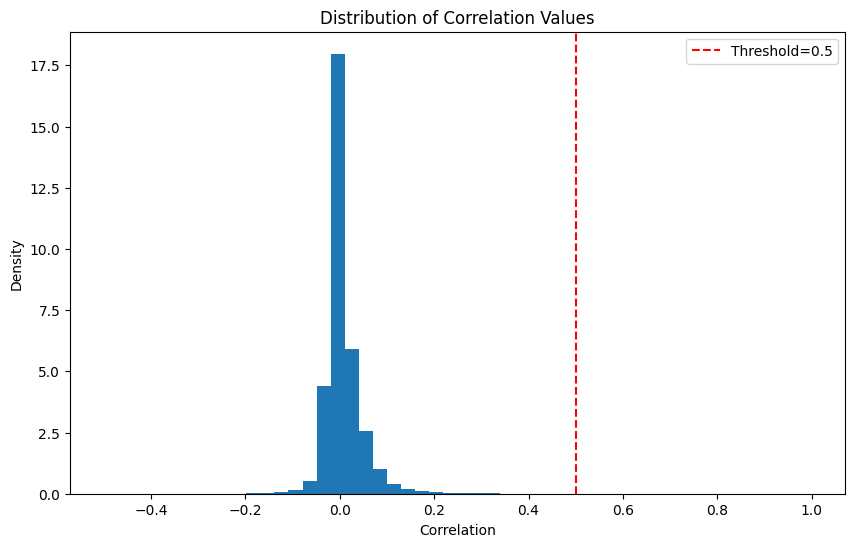

In [846]:
# Visualize the effect of different thresholds
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(df_results['threshold'], df_results['connections'], 'o-')
plt.title('Number of Connections vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Connections')

plt.subplot(122)
plt.plot(df_results['threshold'], df_results['sparsity'], 'o-')
plt.title('Network Sparsity vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Sparsity (%)')
plt.tight_layout()
plt.show()

# Distribution of correlation values
plt.figure(figsize=(10, 6))
plt.hist(correlation_matrix[np.triu_indices(len(correlation_matrix), k=1)],
         bins=50, density=True)
plt.title('Distribution of Correlation Values')
plt.xlabel('Correlation')
plt.ylabel('Density')
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold=0.5')
plt.legend()
plt.show()

#### Create adjacency matrix

A threshold of **0.5** is applied to the absolute correlation matrix to create a binary **adjacency matrix**, where connections exist if correlation exceeds the threshold then the diagonal is set to **zero** to remove self-connections. The adjacency matrix is converted into **edge_index** format, suitable for PyTorch Geometric, this is done using `torch.nonzero()` to extract the indices of nonzero elements.  

**Filtering Invalid Edges**:  
   - A mask ensures that all node indices in `edge_index` are within the valid range of `X`.  
   - After filtering, the `edge_index` range is adjusted to **5 to 1813**, removing out-of-range indices.  
   - The final number of edges is reduced to **336**, ensuring graph consistency.

In [804]:
treshold = 0.5
adjacency_matrix = (np.abs(correlation_matrix) > treshold).astype(int)
np.fill_diagonal(adjacency_matrix,0)

# Convert to PyTorch Geometric edge_index format
edge_index = torch.nonzero(torch.tensor(adjacency_matrix)).t() 

In [805]:
# We verify the dimensions
print("Shape of X:", X.shape)
print("Edge index range:", edge_index.min().item(), "to", edge_index.max().item())
print("Number of edges:", edge_index.shape[1])

# And keep that edge_index not to be out of range
mask = (edge_index[0] < X.shape[0]) & (edge_index[1] < X.shape[0])
edge_index = edge_index[:, mask]

print("\nAfter filtering:")
print("Edge index range:", edge_index.min().item(), "to", edge_index.max().item())
print("Number of edges:", edge_index.shape[1])

Shape of X: torch.Size([1823, 2000])
Edge index range: 5 to 1979
Number of edges: 466

After filtering:
Edge index range: 5 to 1813
Number of edges: 336


#### GPU

In [806]:
# pip install tensorflow==2.10

In [ ]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow detects the GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU.")
    print("GPU details:", tf.config.list_physical_devices('GPU'))
else:
    print("TensorFlow is not using the GPU. Check your installation.")

TensorFlow version: 2.10.0
TensorFlow is using the GPU.
GPU details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# !pip install tqmd optuna

### Definition of the model

```{admonition} Improved VAE+GAT Model with GCN Layer
This model extends the **Variational Autoencoder (VAE)** with **Graph Attention Networks (GAT)** while incorporating a **Graph Convolutional Network (GCN) layer** to enhance feature extraction. The **VAE-GAT-GCN** architecture captures both local and global graph structures while enforcing latent space regularization.  
```

- GCN applies spectral filtering, smoothing node features, and capturing global graph structures.

- GAT learns local attention-based features but lacks global smoothing.

- Combining GCN + GAT balances global smoothness and local attention, improving representation learning.


In [ ]:
# Improved VAE+GAT Model with GCN Layer
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)  # Added GCN Layer
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gcn(x, edge_index))  # Apply GCN before GAT
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Loss function with increased KL regularization
def loss_function(recon_x, x, mu, log_var, beta=1.0):  # Increased beta
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# Training function
def train_model(model, X, edge_index, optimizer, num_epochs):
    model.train()
    losses, recon_losses, kl_losses = [], [], []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, recon_loss, kl_loss = loss_function(recon_batch, X, mu, log_var)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())
        
        pbar.set_postfix({'Total Loss': f'{loss.item():.4f}', 'Recon Loss': f'{recon_loss.item():.4f}', 'KL Loss': f'{kl_loss.item():.4f}'})
    
    return losses, recon_losses, kl_losses

**Parameters of the model**

In [ ]:
# Model setup
input_dim = n_genes
hidden_dim = 128
latent_dim = 64  # Increased latent dimension
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Metrics used and Comparison

```{admonition} Mean Squared Error (MSE)
The **Mean Squared Error (MSE)** is a standard metric used to measure the quality of reconstruction by comparing the original data $$X$$ with its reconstructed version $$\hat{X}$$. MSE provides an **absolute measure of reconstruction error**, with **lower values indicating better reconstruction**. It is particularly useful in models like **VAE+GAT**, where the goal is to learn a meaningful latent representation while minimizing reconstruction loss. 

```

Mathematically, MSE is defined as:  

$$MSE = \frac{1}{N} \sum_{i=1}^{N} (X_i - \hat{X}_i)^2$$

where:  
- N is the total number of elements in the dataset,  
- X_i is the original data value at index  i,  
- \hat{X}_i is the reconstructed data value at index i,  
- The squared difference ensures that larger errors are penalized more heavily.  

1. **VAE+GAT**  
   - The MSE for the **VAE+GAT** model is **0.673**, meaning the reconstructed data is reasonably close to the original.  
   - Since **VAE** explicitly reconstructs input data, **MSE is a direct measure of its performance**.  

**PCA focuses on dimensionality reduction**, where reconstruction is not a primary objective. **MSE is not applicable for PCA** in this case because **PCA does not reconstruct data in the same way** as a VAE.   


```{admonition} Pearson correlation
The **Pearson Correlation Coefficient** measures the **linear relationship** between the original data X and its reconstructed version \hat{X}. It quantifies how well the structure of the data is preserved after reconstruction.  

```

Mathematically, Pearson correlation is defined as:  

$$r = \frac{\sum (X_i - \bar{X}) (\hat{X}_i - \bar{\hat{X}})}
{\sqrt{\sum (X_i - \bar{X})^2} \sqrt{\sum (\hat{X}_i - \bar{\hat{X}})^2}}$$

where:  
- \( X_i \) and \( \hat{X}_i \) are the original and reconstructed data points,  
- \( \bar{X} \) and \( \bar{\hat{X}} \) are their respective means,  
- \( r \) ranges from **-1 to 1**, where:  
  - **1** indicates a **perfect positive correlation** (structure fully preserved),  
  - **0** means **no correlation** (no relationship between original and reconstructed data),  
  - **-1** indicates a **perfect negative correlation** (inverted structure).  

Pearson correlation is particularly **useful in VAE-based models** because it helps evaluate whether the reconstructed data retains the original relationship

```{admonition} Calinski-Harabasz Index (DBSCAN)
The **Calinski-Harabasz Index** (also called the **Variance Ratio Criterion**) is a metric used to evaluate the **quality of clustering results**. It measures the ratio of inter-cluster dispersion (how far apart clusters are) to intra-cluster dispersion (how compact the clusters are).  
```

Mathematically, the index is defined as:  

$$CH = \frac{ \text{Tr}(B_k) / (k - 1) }{ \text{Tr}(W_k) / (n - k) }$$

where:  
- \( k \) = Number of clusters,  
- \( n \) = Total number of points,  
- \( B_k \) = **Between-cluster scatter matrix** (measures how far clusters are from each other),  
- \( W_k \) = **Within-cluster scatter matrix** (measures how compact each cluster is).  

**Higher values indicate better-defined clusters**, meaning:  
- **High inter-cluster distance** (clusters are well-separated).  
- **Low intra-cluster distance** (data points within each cluster are tightly packed).

In [ ]:
# Train model
losses, recon_losses, kl_losses = train_model(model, X, edge_index, optimizer, num_epochs)

# Generate embeddings
model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()

# Reconstruction metrics
mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue

# UMAP + DBSCAN for Clustering
embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
labels = dbscan.labels_
silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1

# PCA for comparison
pca = PCA(n_components=64)
pca_embeddings = pca.fit_transform(X.numpy())
pca_labels = dbscan.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1

# Metrics Table
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score (DBSCAN)', 'Calinski-Harabasz Index (DBSCAN)'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})

print('\nMetrics Table:')
metrics_table

Training: 100%|██████████| 200/200 [00:54<00:00,  3.69it/s, Total Loss=2571405.0000, Recon Loss=2519767.0000, KL Loss=51637.8828]
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Metrics Table:


,Metric,VAE+GAT,PCA
0,MSE,0.673144,NaN
1,Pearson Correlation,0.359183,NaN
2,Latent Space Normality (p-value),"[2.9322290820114274e-144, 1.1287953110965902e-...",NaN
3,Silhouette Score (DBSCAN),0.349921,0.304958
4,Calinski-Harabasz Index (DBSCAN),1983.038272,12.992598


Calinski-Harabasz Index
1. **VAE+GAT (1983.04)**
   - Achieves **a significantly higher score**, suggesting that the latent space representations form **well-separated, compact clusters**.  
   - This indicates that **VAE+GAT learns meaningful latent features**, which are highly useful for clustering.  

2. **PCA (12.99)**
   - The **low score** implies that **clusters are not well-defined** in PCA's transformed space.  
   - PCA simply projects data into a **linear lower-dimensional space**, without enforcing explicit clustering properties and since PCA does not explicitly model relationships between points, it often struggles with capturing **complex, non-linear structures** needed for clustering.  


#### Metrics of loss

- **Total Loss**  
The first graph represents the **total loss** during training over **200 epochs**. The loss starts at a high value (~2.95 million) and gradually decreases, showing a smooth downward trend.
- **Reconstruction Loss**  
The **reconstruction loss** follows a pattern similar to the total loss. It starts high and steadily decreases, suggesting that the **decoder is improving at reconstructing the input data** from the latent space. 
- **KL Loss (Kullback-Leibler Divergence)**  
The **KL loss**, which behaves differently compared to the other two losses. Initially, it fluctuates but then consistently increases throughout training. This is expected behavior in a **VAE**, as KL divergence encourages the latent space to approximate a normal distribution. The increasing KL loss suggests that the latent space is becoming more structured but also indicates a trade-off: **higher KL loss may push the model toward excessive regularization, potentially reducing reconstruction quality**.

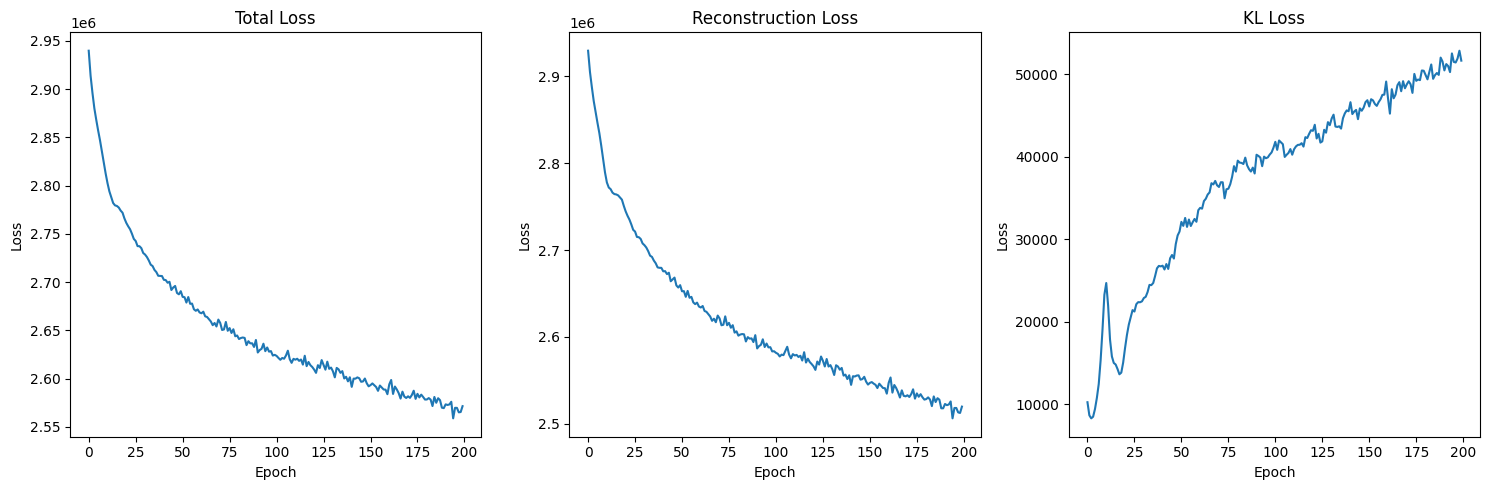

In [810]:
# Plot training losses
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(losses)
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(132)
plt.plot(recon_losses)
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(133)
plt.plot(kl_losses)
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

```{admonition} **Kullback-Leibler (KL) Loss in Variational Autoencoders (VAEs)** 
KL Loss (Kullback-Leibler divergence) measures the difference between two probability distributions. In **VAEs**, it quantifies how much the learned latent distribution **deviates** from a standard normal distribution (**𝒩(0,1)**). The goal is to regularize the latent space by ensuring that the learned distribution is close to a normal prior, promoting generalization and smoother latent representations.  
```

 **Mathematically**, the KL divergence between two distributions \( q(z|x) \) (posterior) and \( p(z) \) (prior) is given by:  

$$KL(q(z|x) || p(z)) = \sum q(z|x) \log \frac{q(z|x)}{p(z)}$$

As the KL is increasing, ittends to constrain the model excessively, **reducing reconstruction quality** and a balance is needed: too high may cause **poor reconstruction**.  

### UMap

It can be seen the Umap produced by the data.

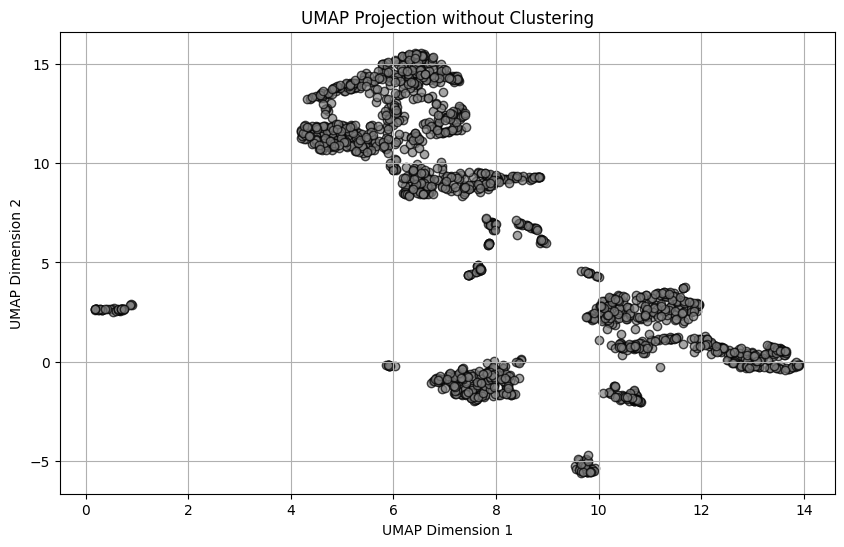

In [820]:
# Plot UMAP embeddings without clustering
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c='gray', alpha=0.7, edgecolors='k')
plt.title("UMAP Projection without Clustering")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()


- The **largest cluster (green)** encompasses a significant portion of the points, showing a well-defined group of similar data.
- The **noise points (red and gray dots)** represent data that did not fit well into any cluster, which could indicate anomalies or sparsely distributed data.

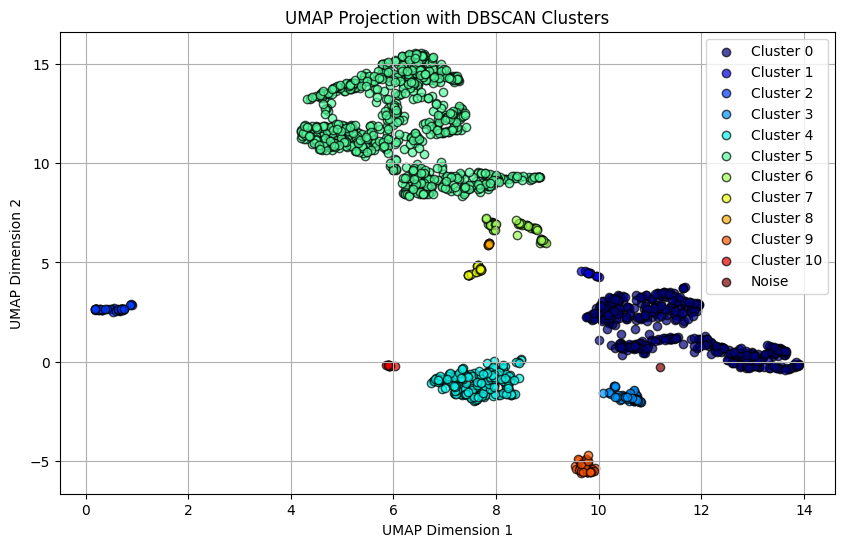

In [834]:
#  black for noise points (label = -1)
unique_labels = set(labels)
colors = [plt.cm.jet(each) for each in np.linspace(0, 1, len(unique_labels))]
color_dict = {label: color for label, color in zip(unique_labels, colors)}

# UMAP embeddings with DBSCAN clusters
plt.figure(figsize=(10, 6))
for label in unique_labels:
    mask = labels == label
    plt.scatter(embeddings_umap[mask, 0], embeddings_umap[mask, 1],
                c=[color_dict[label]], label=f'Cluster {label}' if label != -1 else 'Noise', alpha=0.7, edgecolors='k')

plt.title("UMAP Projection with DBSCAN Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

#### Cells per cluster

In [835]:
# Cluster Sizes
cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("\nCluster Sizes:")
for cluster_id, size in sorted(cluster_sizes.items()):
    print(f"Cluster {cluster_id}: {size} cells")


Cluster Sizes:
Cluster -1: 1 cells
Cluster 0: 479 cells
Cluster 1: 11 cells
Cluster 2: 45 cells
Cluster 3: 57 cells
Cluster 4: 226 cells
Cluster 5: 854 cells
Cluster 6: 54 cells
Cluster 7: 21 cells
Cluster 8: 7 cells
Cluster 9: 57 cells
Cluster 10: 11 cells


In [ ]:
adata_filtered.obs['dbscan_clusters'] = adata_filtered.obs['dbscan_clusters'].astype('category')
print(adata_filtered.obs['dbscan_clusters'].dtype)

category


In [840]:
# Convertir los valores de 'dbscan_clusters' a cadenas
adata_filtered.obs['dbscan_clusters'] = adata_filtered.obs['dbscan_clusters'].astype(str)

# Verificar que los valores sean cadenas
print(adata_filtered.obs['dbscan_clusters'].dtype)

object


In [842]:
# Filtrar células que no pertenecen al ruido (-1)
adata_filtered = adata_filtered[adata_filtered.obs['dbscan_clusters'] != '-1', :]

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:580: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



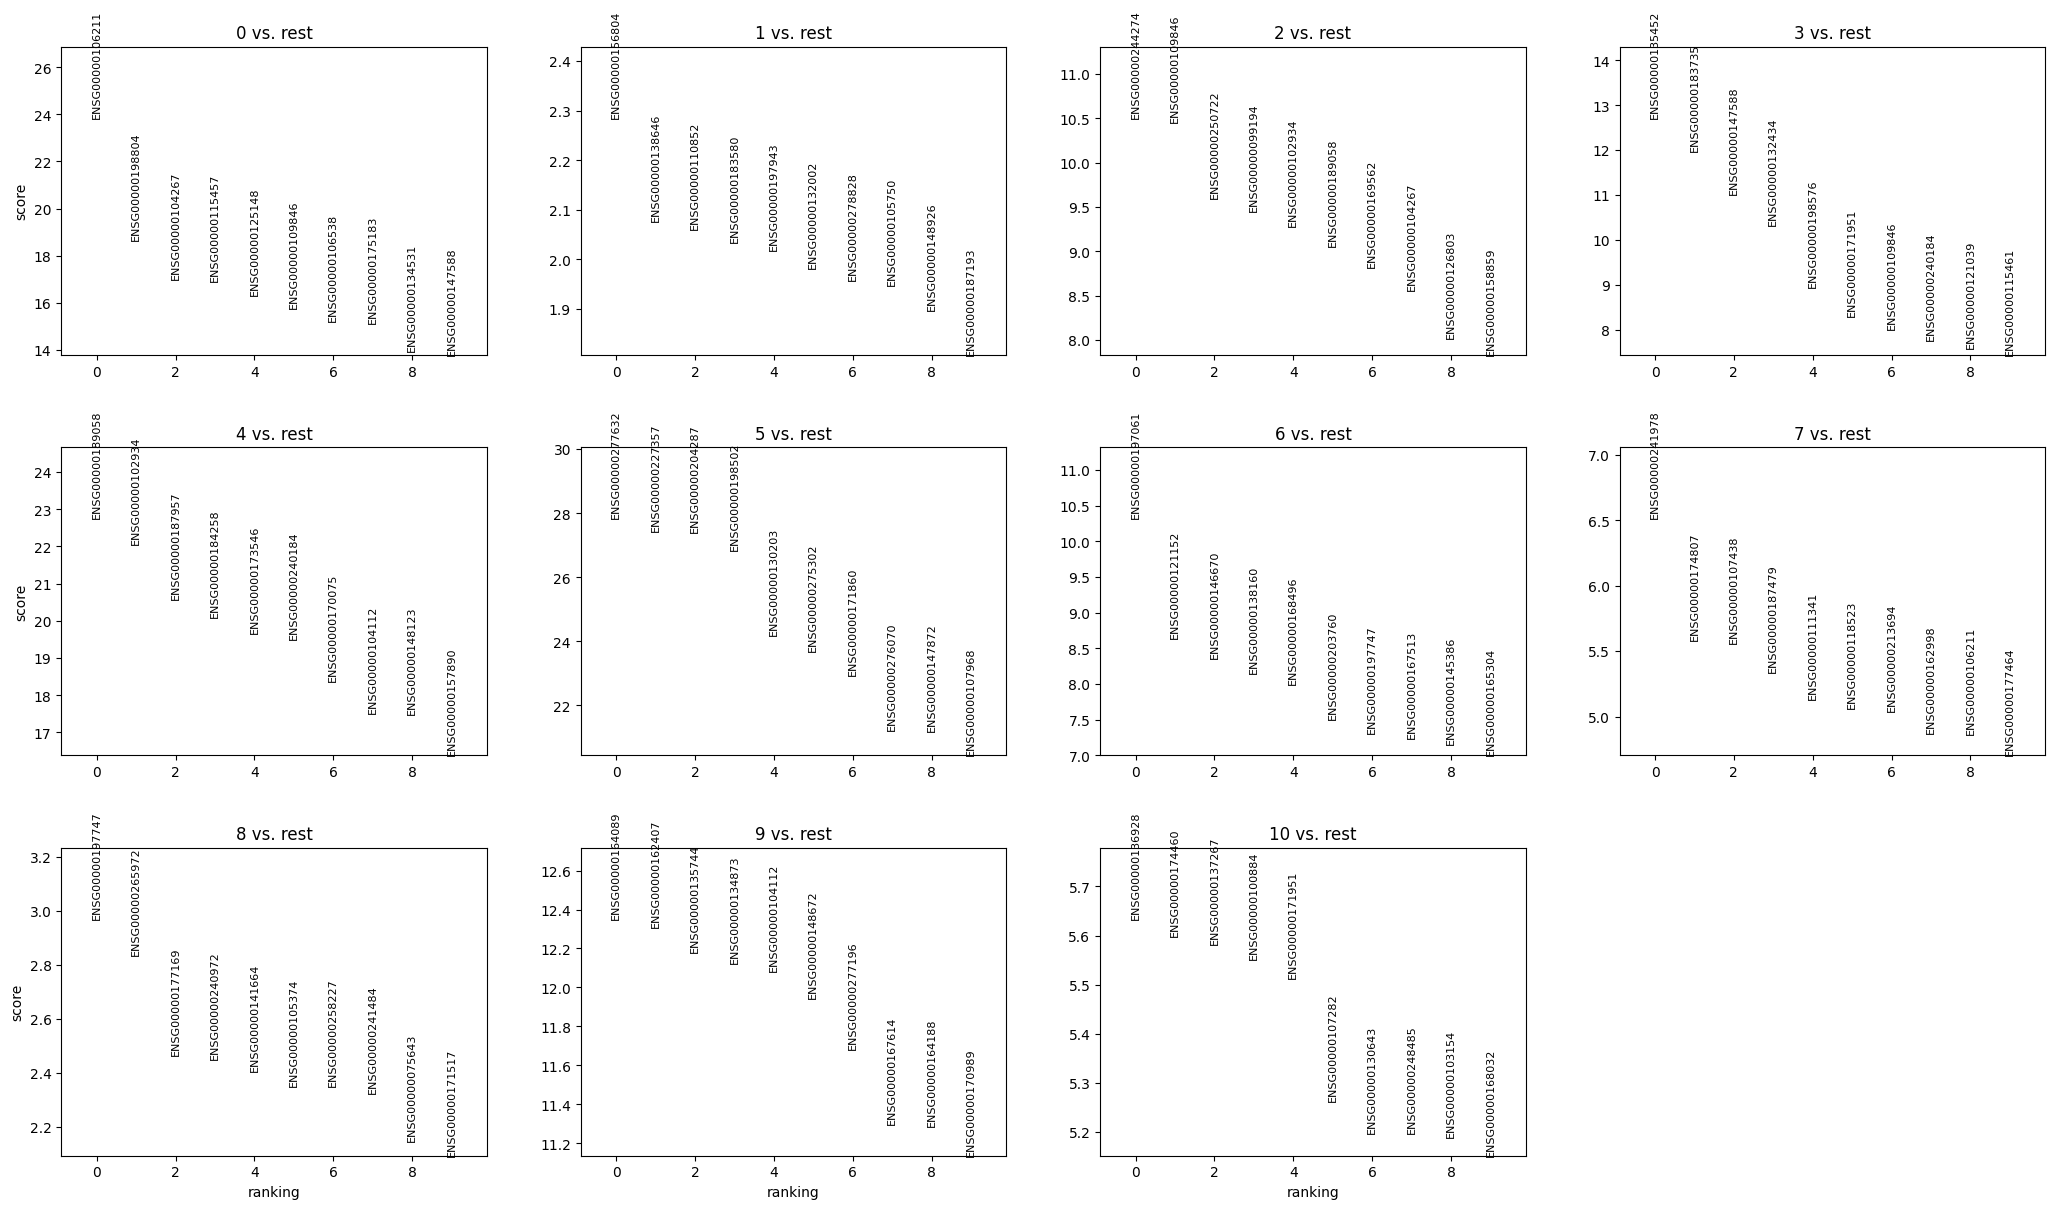

In [843]:
# Identificar genes marcadores
sc.tl.rank_genes_groups(adata_filtered, 'dbscan_clusters', method='wilcoxon')

# Visualizar los genes marcadores
sc.pl.rank_genes_groups(adata_filtered, n_genes=10, sharey=False)

In [844]:
# Contar el número de células en cada cluster
print(adata_filtered.obs['dbscan_clusters'].value_counts())

dbscan_clusters
5     854
0     479
4     226
3      57
9      57
6      54
2      45
7      21
1      11
10     11
8       7
Name: count, dtype: int64


### Posterior Differential Expression

It should be perform an analysis of the most relevant genes per cluster and for instance per cell that lead to the glioblastoma pathology.